In [2]:
# Import the pandas library, giving it the standard alias 'pd'
import pandas as pd

# Load our log data from the CSV file into a pandas DataFrame
# A DataFrame is like a powerful, programmable spreadsheet.
df = pd.read_csv('mock_logs.csv')

# Display the first 5 rows of our data to make sure it loaded correctly
print("--- Log Data Loaded ---")
print(df.head())

# Use the .info() method to get a summary of the data types and check for missing values
print("\n--- Data Information ---")
df.info()

--- Log Data Loaded ---
              timestamp host_id  status_code  response_time_ms
0  2023-10-30T10:00:00Z  host_A          200                50
1  2023-10-30T10:00:01Z  host_B          200                65
2  2023-10-30T10:00:02Z  host_C          503              1200
3  2023-10-30T10:00:03Z  host_A          200                55
4  2023-10-30T10:00:04Z  host_B          200                70

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   timestamp         12 non-null     object
 1   host_id           12 non-null     object
 2   status_code       12 non-null     int64 
 3   response_time_ms  12 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 516.0+ bytes


In [3]:
# --- Lesson 1.3: Calculating Success and Failure Rates ---

# First, let's identify what counts as a 'failure'. 
# In server logs, status codes in the 500-599 range are server errors.
# We'll create a new column called 'is_failure'. 
# It will be 1 if the status_code is 500 or greater, and 0 otherwise.

df['is_failure'] = (df['status_code'] >= 500).astype(int)

print("--- DataFrame with 'is_failure' column ---")
print(df)


# Now, we'll use one of the most powerful features of pandas: groupby().
# This lets us group all the rows by the 'host_id' and then perform calculations on each group.

# We group by 'host_id' and then use .agg() to perform multiple aggregations (calculations) at once.
host_summary = df.groupby('host_id').agg(
    total_requests=('timestamp', 'count'),  # Count the total number of requests for each host
    total_failures=('is_failure', 'sum')    # Sum the 'is_failure' column (since failures are 1 and successes are 0)
)

print("\n--- Host Summary (Counts) ---")
print(host_summary)


# Now we can calculate the failure rate for each host.
# Failure Rate = (Total Failures / Total Requests) * 100
host_summary['failure_rate_%'] = (host_summary['total_failures'] / host_summary['total_requests']) * 100

# Let's sort the results to easily see the worst-performing host.
host_summary = host_summary.sort_values(by='failure_rate_%', ascending=False)


# Display the final, insightful result
print("\n--- Final Host Performance Report ---")
print(host_summary)

--- DataFrame with 'is_failure' column ---
               timestamp host_id  status_code  response_time_ms  is_failure
0   2023-10-30T10:00:00Z  host_A          200                50           0
1   2023-10-30T10:00:01Z  host_B          200                65           0
2   2023-10-30T10:00:02Z  host_C          503              1200           1
3   2023-10-30T10:00:03Z  host_A          200                55           0
4   2023-10-30T10:00:04Z  host_B          200                70           0
5   2023-10-30T10:00:05Z  host_C          503              1500           1
6   2023-10-30T10:00:06Z  host_A          500              1100           1
7   2023-10-30T10:00:07Z  host_B          200                60           0
8   2023-10-30T10:00:08Z  host_C          503              1350           1
9   2023-10-30T10:00:09Z  host_A          200                48           0
10  2023-10-30T10:00:10Z  host_B          500              1050           1
11  2023-10-30T10:00:11Z  host_C          200

In [4]:
# --- Lesson 2. химический факультет: Analyzing Response Times and Standard Deviation ---

# Let's first look at the response times for ONLY the successful requests.
# A failed request with a high response time (e.g., a timeout) can skew our analysis of normal performance.
successful_requests = df[df['is_failure'] == 0]

print("--- Successful Requests Only ---")
print(successful_requests)


# Now, let's use groupby() again on these successful requests to calculate statistics for response_time_ms.
response_time_stats = successful_requests.groupby('host_id')['response_time_ms'].agg(
    avg_response_time_ms='mean',  # Calculate the average (mean) response time
    std_dev_response_time='std'   # Calculate the standard deviation
)

print("\n--- Response Time Statistics ---")
print(response_time_stats)


# Standard deviation can be hard to interpret on its own. A value of 'NaN' (Not a Number) means
# there was only one data point, so a standard deviation can't be calculated. Let's fill those with 0.
response_time_stats = response_time_stats.fillna(0)


# Now, let's merge these new stats back into our main host_summary table.
# We use pd.merge to join the two tables together based on their index (the host_id).
host_summary = pd.merge(host_summary, response_time_stats, left_index=True, right_index=True, how='left')


# Display the updated, comprehensive report
print("\n--- Updated Host Performance Report with Response Times ---")
print(host_summary)

--- Successful Requests Only ---
               timestamp host_id  status_code  response_time_ms  is_failure
0   2023-10-30T10:00:00Z  host_A          200                50           0
1   2023-10-30T10:00:01Z  host_B          200                65           0
3   2023-10-30T10:00:03Z  host_A          200                55           0
4   2023-10-30T10:00:04Z  host_B          200                70           0
7   2023-10-30T10:00:07Z  host_B          200                60           0
9   2023-10-30T10:00:09Z  host_A          200                48           0
11  2023-10-30T10:00:11Z  host_C          200                80           0

--- Response Time Statistics ---
         avg_response_time_ms  std_dev_response_time
host_id                                             
host_A                   51.0               3.605551
host_B                   65.0               5.000000
host_C                   80.0                    NaN

--- Updated Host Performance Report with Response Times ---

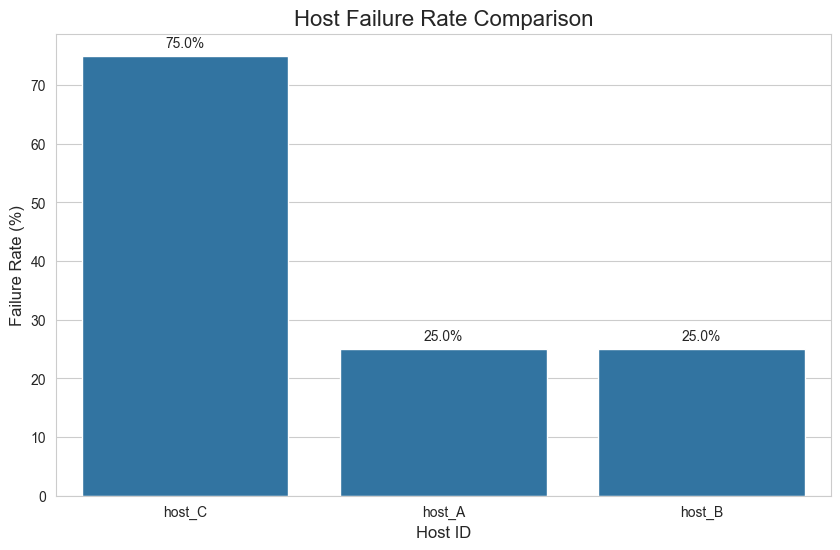

In [5]:
# --- Lesson 3.1: Visualizing Failure Rates ---

# Import the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional style for the plots
sns.set_style("whitegrid")

# --- Chart 1: Comparing Host Failure Rates ---

# Reset the index of our summary table so 'host_id' becomes a regular column.
# This makes it easier for Seaborn to use for plotting.
plot_data = host_summary.reset_index()

plt.figure(figsize=(10, 6))  # Create a figure to draw on, with a specific size

# Create the bar plot using Seaborn.
# x='host_id' -> Use the host IDs on the x-axis.
# y='failure_rate_%' -> Use the failure rate for the height of the bars.
# data=plot_data -> The DataFrame containing our data.
ax = sns.barplot(x='host_id', y='failure_rate_%', data=plot_data)

# Add titles and labels for clarity
ax.set_title('Host Failure Rate Comparison', fontsize=16)
ax.set_xlabel('Host ID', fontsize=12)
ax.set_ylabel('Failure Rate (%)', fontsize=12)

# Add the exact percentage on top of each bar for more detail
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show() # Display the plot

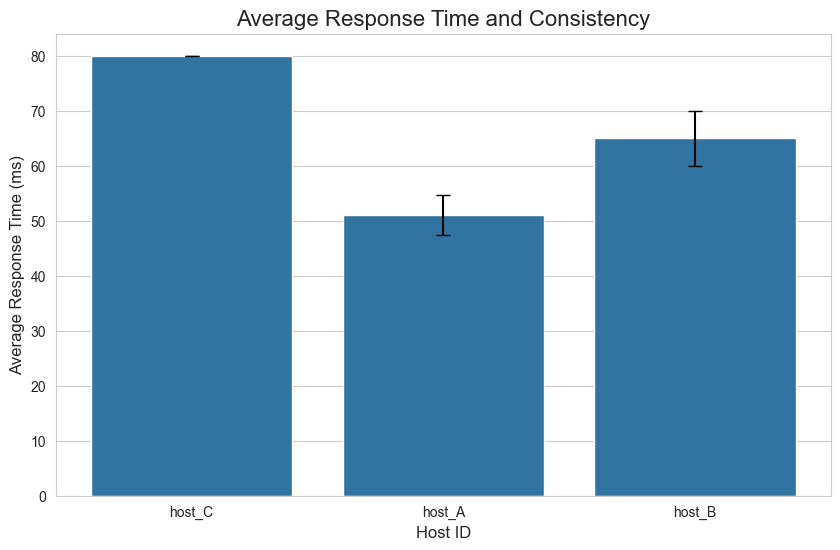

In [6]:
# --- Lesson 3.2: Visualizing Response Times with Standard Deviation ---

plt.figure(figsize=(10, 6))

# Create the bar plot for average response time
ax2 = sns.barplot(x='host_id', y='avg_response_time_ms', data=plot_data)

# --- THIS IS THE KEY PART ---
# Add "error bars" to the chart. The length of these bars will represent the standard deviation.
# A longer error bar means the host is less consistent.
plt.errorbar(x=plot_data['host_id'], 
             y=plot_data['avg_response_time_ms'], 
             yerr=plot_data['std_dev_response_time'],  # Use the std_dev column for the error size
             fmt='none',                              # 'none' means don't draw a marker
             ecolor='black',                          # Color of the error bars
             capsize=5)                               # The small caps at the end of the bars

# Add titles and labels
ax2.set_title('Average Response Time and Consistency', fontsize=16)
ax2.set_xlabel('Host ID', fontsize=12)
ax2.set_ylabel('Average Response Time (ms)', fontsize=12)

plt.show()

In [7]:
# --- Lesson 4.1: Detecting Consecutive Failure Patterns ---

# First, we need our data sorted by time for each host to properly detect 'consecutive' events.
# We'll sort by host_id first, then by the timestamp.
df_sorted = df.sort_values(by=['host_id', 'timestamp'])

print("--- Data sorted for pattern detection ---")
print(df_sorted.head(10)) # Display the first 10 rows of the sorted data


def find_consecutive_failures(host_logs, threshold=2):
    """
    This function takes a DataFrame of logs for a single host and
    finds the maximum number of consecutive failures.
    
    Args:
        host_logs (pd.DataFrame): The log data for one host.
        threshold (int): The number of consecutive failures to look for.

    Returns:
        int: The number of times the consecutive failure threshold was met or exceeded.
    """
    consecutive_failures_count = 0
    max_consecutive_streaks_found = 0
    
    # Iterate through each row of the host's logs
    for is_failure in host_logs['is_failure']:
        if is_failure == 1:
            # If it's a failure, increment our counter
            consecutive_failures_count += 1
        else:
            # If it's a success, reset the counter
            consecutive_failures_count = 0
            
        # Check if the current streak has just met our threshold
        if consecutive_failures_count == threshold:
            max_consecutive_streaks_found += 1
            
    return max_consecutive_streaks_found


# --- Apply the function to our data ---

# We use groupby('host_id') again, but this time we .apply() our custom function to each group.
# This is a very powerful pattern in Pandas for complex, group-specific analysis.
consecutive_failure_incidents = df_sorted.groupby('host_id').apply(
    lambda x: find_consecutive_failures(x, threshold=2) # We'll set the threshold to 2 for our small dataset
)

# The result is a Pandas Series. Let's convert it to a DataFrame and rename the column.
consecutive_failure_incidents = consecutive_failure_incidents.to_frame(name='consecutive_failure_events')


print("\n--- Consecutive Failure Incidents (2 or more in a row) ---")
print(consecutive_failure_incidents)


# Finally, let's merge this new insight into our main summary table
host_summary = pd.merge(host_summary, consecutive_failure_incidents, left_index=True, right_index=True, how='left')

print("\n--- FINAL COMPREHENSIVE HOST PERFORMANCE REPORT ---")
print(host_summary)

--- Data sorted for pattern detection ---
               timestamp host_id  status_code  response_time_ms  is_failure
0   2023-10-30T10:00:00Z  host_A          200                50           0
3   2023-10-30T10:00:03Z  host_A          200                55           0
6   2023-10-30T10:00:06Z  host_A          500              1100           1
9   2023-10-30T10:00:09Z  host_A          200                48           0
1   2023-10-30T10:00:01Z  host_B          200                65           0
4   2023-10-30T10:00:04Z  host_B          200                70           0
7   2023-10-30T10:00:07Z  host_B          200                60           0
10  2023-10-30T10:00:10Z  host_B          500              1050           1
2   2023-10-30T10:00:02Z  host_C          503              1200           1
5   2023-10-30T10:00:05Z  host_C          503              1500           1

--- Consecutive Failure Incidents (2 or more in a row) ---
         consecutive_failure_events
host_id                   

C:\Users\1\AppData\Local\Temp\ipykernel_22688\873187701.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consecutive_failure_incidents = df_sorted.groupby('host_id').apply(
